In [80]:
import itertools
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [82]:
DATA_ROOT = '../data/'
READ_DIR = os.path.join(DATA_ROOT, 'raw/bos_analyze')
WRITE_DIR = os.path.join(DATA_ROOT, 'interim')
readfile = os.path.join(READ_DIR, 'SAMaddresses.csv')

print(readfile)

../data/raw/bos_analyze/SAMaddresses.csv


In [2]:
df_sam = pd.read_csv(readfile, dtype={'FULL_STREET_NAME':str})

/home/sedelmeyer/anaconda3/envs/cs109a/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (8,9,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(df_sam.info())
df_sam.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398702 entries, 0 to 398701
Data columns (total 27 columns):
X                       398702 non-null float64
Y                       398702 non-null float64
SAM_ADDRESS_ID          398702 non-null int64
RELATIONSHIP_TYPE       398702 non-null int64
BUILDING_ID             398702 non-null int64
FULL_ADDRESS            398702 non-null object
STREET_NUMBER           398702 non-null object
IS_RANGE                398702 non-null int64
RANGE_FROM              26175 non-null object
RANGE_TO                26175 non-null object
UNIT                    270100 non-null object
FULL_STREET_NAME        398702 non-null object
STREET_ID               398702 non-null int64
STREET_PREFIX           398702 non-null object
STREET_BODY             398702 non-null object
STREET_SUFFIX_ABBR      394519 non-null object
STREET_FULL_SUFFIX      394519 non-null object
STREET_SUFFIX_DIR       398702 non-null object
STREET_NUMBER_SORT      398702 non-null float64


,X,Y,SAM_ADDRESS_ID,RELATIONSHIP_TYPE,BUILDING_ID,FULL_ADDRESS,STREET_NUMBER,IS_RANGE,RANGE_FROM,RANGE_TO,...,STREET_SUFFIX_DIR,STREET_NUMBER_SORT,MAILING_NEIGHBORHOOD,ZIP_CODE,X_COORD,Y_COORD,SAM_STREET_ID,WARD,PRECINCT_WARD,PARCEL
0,-71.125037,42.250627,1,1,100778,6-10 A St,6-10,1,6,10,...,,10.0,Hyde Park,2136.0,757684.428550,2.916575e+06,1,18,1818,1.809309e+09
1,-71.124891,42.250328,2,1,126344,15 A St,15,0,NaN,NaN,...,,15.0,Hyde Park,2136.0,757724.178238,2.916467e+06,1,18,1818,1.809331e+09
2,-71.125401,42.250469,4,1,100797,7 A St,7,0,NaN,NaN,...,,7.0,Hyde Park,2136.0,757586.116749,2.916517e+06,1,18,1818,1.809337e+09
3,-71.056801,42.340889,11,1,154909,10 A St,10,0,NaN,NaN,...,,10.0,South Boston,2127.0,775987.559326,2.949557e+06,2,6,0601,6.000900e+08
4,-71.053149,42.344846,16,1,141250,172-174 A St,172-174,1,172,174,...,,172.0,Boston,2210.0,776967.328447,2.951004e+06,2,6,0601,6.027430e+08


In [4]:
df_locs = df_sam[['X', 'Y', 'FULL_STREET_NAME', 'STREET_ID']].sort_values(by=['STREET_ID', 'X', 'Y'])
print(len(df_locs))
df_locs = df_locs.drop_duplicates()
print(len(df_locs))

398702
175354


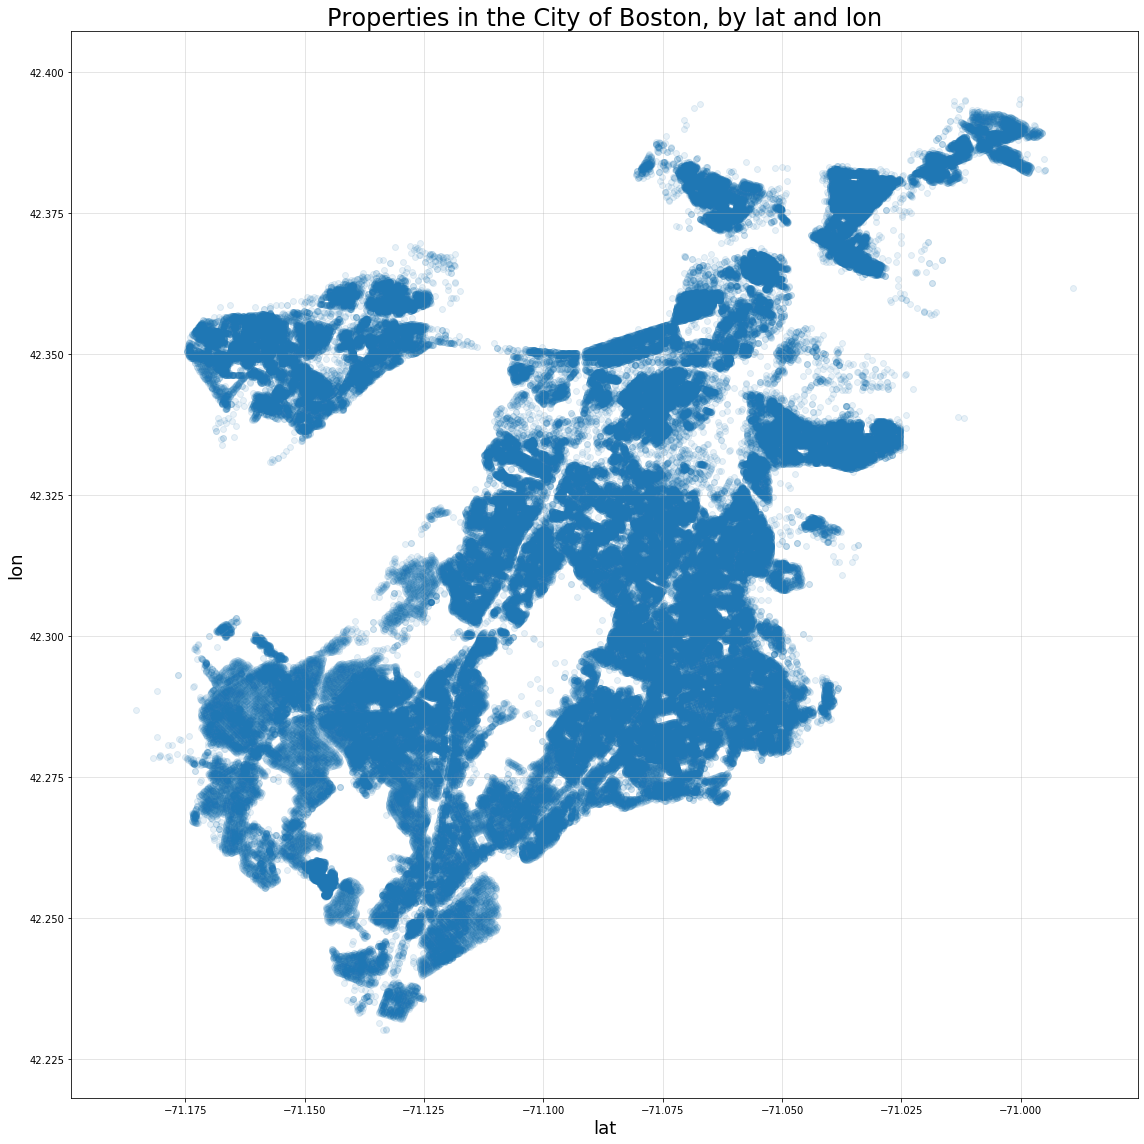

CPU times: user 1.2 s, sys: 3.94 ms, total: 1.21 s
Wall time: 1.2 s


In [65]:
%%time

fig, ax = plt.subplots(figsize=(16,16))
plt.title('Properties in the City of Boston, by lat and lon', fontsize=24)
plt.scatter(df_locs['X'], df_locs['Y'], alpha=0.1)
plt.xlabel('lat', fontsize=18)
plt.ylabel('lon', fontsize=18)
plt.grid(":", alpha=0.4)
plt.tight_layout()
plt.show();

In [6]:
%%time
prop_streets = df_locs['FULL_STREET_NAME'].value_counts().sort_index().index
street_ids = df_locs['STREET_ID'].value_counts().sort_index().index
street_id_key = df_locs.groupby('STREET_ID').agg(
    {
        'FULL_STREET_NAME': 'first'
    }
)
street_id_combos = np.array(list(itertools.combinations(street_ids, 2)))

CPU times: user 3.13 s, sys: 205 ms, total: 3.33 s
Wall time: 3.34 s


In [7]:
len(prop_streets), len(street_ids), len(street_id_key), street_id_combos.shape

(4085, 4350, 4350, (9459075, 2))

In [8]:
print(street_id_combos[:5])
street_id_key.head()

[[1 2]
 [1 3]
 [1 4]
 [1 5]
 [1 6]]


,FULL_STREET_NAME
STREET_ID,
1,A St
2,A St
3,Abbot St
4,Abbotsford St
5,Abby Rd


In [9]:
%%time

street_arrays = {
    street_id: df_locs.loc[df_locs['STREET_ID']==street_id][['X', 'Y']].values
    for street_id in street_ids
}

CPU times: user 5.01 s, sys: 19.7 ms, total: 5.03 s
Wall time: 5.03 s


In [10]:
len(street_arrays)

4350

In [14]:
def distances(locs1, locs2):
    """
    Calculates Euclidian distance between two lat/lon coordinates. This
    acts as a simplified (and more efficient) calculation than converting
    lat/lon to a constant measure of distance
    """
    d0 = np.subtract.outer(locs1[:,0], locs2[:,0])
    d1 = np.subtract.outer(locs1[:,1], locs2[:,1])
    return np.hypot(d0, d1)


def id_intersections(street_id_combos, street_arrays, street_id_map_dict, threshold, verbose=False):
    """
    returns: pd.DataFrame containing intersection locations
    """
    street_arrays_distances = np.array([
        np.array(distances(street_arrays[combo[0]], street_arrays[combo[1]]))
        for combo in street_id_combos
    ])
        
    intersections_bool = np.array([
        np.min(distances) < threshold
        for distances in street_arrays_distances
    ])
        
    shortest_dist_indices = np.array([
        np.argwhere(distances == np.min(distances))[0][0]
        for distances in street_arrays_distances[intersections_bool]
    ])
    
    intersections_id_combos = street_id_combos[intersections_bool]
    
    street_arrays_intersections = np.array([
        street_arrays[combo[0]]
        for combo in intersections_id_combos
    ])
        
    intersection_coords = np.array([
        street_arrays_intersections[i][shortest_dist_index]
        for i, shortest_dist_index in enumerate(shortest_dist_indices)
    ])

    if verbose:
        print(
            '{0:,} street arrays distances calculated, '\
            '{1:,} intersection coordinates returned '\
            'with a threshold of {2:}.'.format(
                len(street_arrays_distances),
                len(intersection_coords),
                threshold
            )
        )

    intersections_df = pd.DataFrame(
        {
            'street_id': intersections_id_combos[:, 0],
            'cross_id': intersections_id_combos[:, 1],
            'street': pd.Series(intersections_id_combos[:,0]).map(street_id_map_dict).values,
            'cross': pd.Series(intersections_id_combos[:,1]).map(street_id_map_dict).values,
            'lat': intersection_coords[:,0],
            'lon': intersection_coords[:,1],
            'threshold': threshold
        }
    )
    
    return intersections_df

In [101]:
locs1 = 2657 # Mass ave
locs2 = 2139 # Huntington Ave
threshold = 0.005

mass_hunt_intersection = id_intersections(
    np.array([[locs1, locs2]]),
    street_arrays,
    street_id_map_dict,
    threshold,
    verbose=False
)

threshold_test = np.array(
    [street_arrays[locs1][120][0]+threshold,
     street_arrays[locs1][120][1]+threshold]
)

In [102]:
mass_hunt_intersection

,street_id,cross_id,street,cross,lat,lon,threshold
0,2657,2139,Massachusetts Ave,Huntington Ave,-71.085683,42.342843,0.005


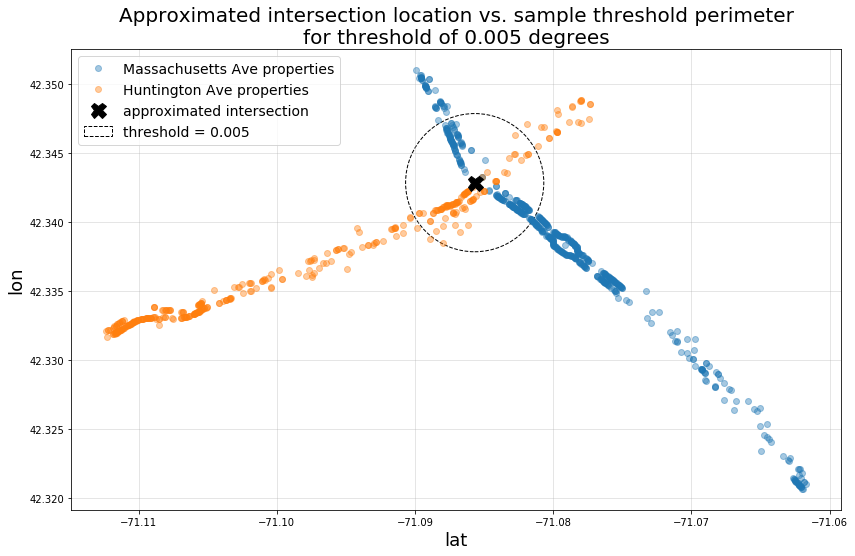

In [103]:
fig, ax = plt.subplots(figsize=(12,12))

plt.title(
    'Approximated intersection location vs. sample threshold perimeter\n'\
    'for threshold of {0} degrees'\
    ''.format(threshold), 
    fontsize=20
)

for street_id in [locs1, locs2]:
    plt.plot(
        street_arrays[street_id][:,0],
        street_arrays[street_id][:,1],
        'o',
        alpha=.4,
        label='{0} properties'.format(street_id_map_dict[street_id])
    )

plt.plot(
    mass_hunt_intersection['lat'],
    mass_hunt_intersection['lon'],
    'kX',
    markersize=15,
    label='approximated intersection'
)
circle = mpatches.Circle(
    xy=[mass_hunt_intersection['lat'], mass_hunt_intersection['lon']],
    radius=threshold,
    ec='k',
    linestyle='--',
    fill=False,
    label='threshold = {0}'.format(threshold)
)
ax.add_patch(circle)
plt.xlabel('lat', fontsize=18)
plt.ylabel('lon', fontsize=18)
ax.set_aspect('equal')
plt.legend(fontsize=14)
plt.grid(':', alpha=0.4)
plt.tight_layout()
plt.show();

In [16]:
%%time
threshold = 0.005
n_splits = 50 # because the kernel will crash if more than 500K are processed at a time
splits = np.array_split(street_id_combos, n_splits)

street_id_map_dict = {
    street_id: street_name
    for street_id, street_name in zip(
        street_id_key.index,
        street_id_key['FULL_STREET_NAME']
    )
}

print('SPLIT 1:')
intersections_df = id_intersections(
    splits[0],
    street_arrays,
    street_id_map_dict,
    threshold,
    verbose=True
)
print()

for i, split in enumerate(splits[1:]):
    print('SPLIT {}:'.format(i+2)) 
    intersections_df = pd.concat(
         [
             intersections_df,
             id_intersections(
                 split,
                 street_arrays,
                 street_id_map_dict,
                 threshold,
                 verbose=True
             )
         ], ignore_index=True
     )
    print('{0:,} cumulative intersections identified\n'.format(len(intersections_df)))

SPLIT 1:
189,182 street arrays distances calculated, 2,776 intersection coordinates returned with a threshold of 0.005

SPLIT 2:
189,182 street arrays distances calculated, 2,657 intersection coordinates returned with a threshold of 0.005
5,433 cumulative intersections identified

SPLIT 3:
189,182 street arrays distances calculated, 2,465 intersection coordinates returned with a threshold of 0.005
7,898 cumulative intersections identified

SPLIT 4:
189,182 street arrays distances calculated, 2,446 intersection coordinates returned with a threshold of 0.005
10,344 cumulative intersections identified

SPLIT 5:
189,182 street arrays distances calculated, 2,724 intersection coordinates returned with a threshold of 0.005
13,068 cumulative intersections identified

SPLIT 6:
189,182 street arrays distances calculated, 2,481 intersection coordinates returned with a threshold of 0.005
15,549 cumulative intersections identified

SPLIT 7:
189,182 street arrays distances calculated, 2,597 intersec

In [18]:
intersections_df.shape

(129204, 7)

In [105]:
intersections_df.head()

,street_id,cross_id,street,cross,lat,lon,threshold
0,1,20,A St,Adams St,-71.125670,42.250592,0.005
1,1,81,A St,Allen St,-71.125670,42.250592,0.005
2,1,242,A St,Averbuch Ter,-71.125670,42.250592,0.005
3,1,251,A St,B St,-71.125401,42.250469,0.005
4,1,252,A St,B St,-71.125401,42.250469,0.005


In [87]:
intersections_df.to_csv(
    os.path.join(WRITE_DIR, 'intersections-{0}.csv'.format(str(threshold-int(threshold))[2:])),
    index=False
)

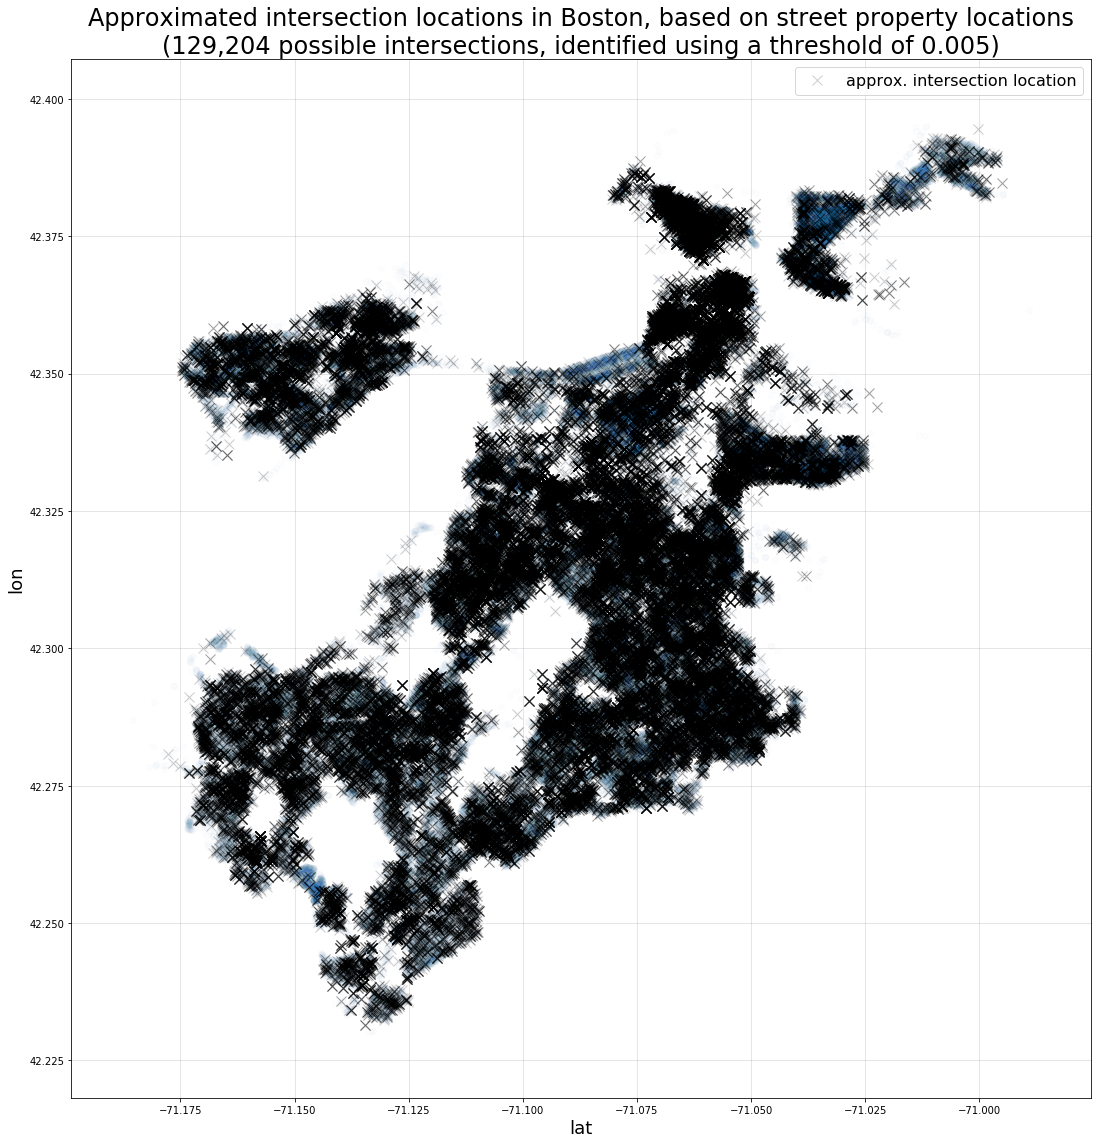

CPU times: user 2.36 s, sys: 8.02 ms, total: 2.37 s
Wall time: 2.37 s


In [104]:
%%time

fig, ax = plt.subplots(figsize=(16,16))
plt.title(
    'Approximated intersection locations in Boston, based on street property locations\n'\
    '({0:,} possible intersections, identified using a threshold of {1})'.format(
        len(intersections_df),
        threshold
    ), 
    fontsize=24
)
plt.scatter(df_locs['X'], df_locs['Y'], alpha=0.01)
plt.plot(
    intersections_df['lat'],
    intersections_df['lon'],
    'kx',
    markersize=10,
    alpha=0.2,
    label='approx. intersection location'
)
plt.xlabel('lat', fontsize=18)
plt.ylabel('lon', fontsize=18)
plt.grid(":", alpha=0.4)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show();

In [96]:
street_id_key[street_id_key['FULL_STREET_NAME'].str.contains('American Legion')]

,FULL_STREET_NAME
STREET_ID,
112,American Legion Hwy


In [99]:
street_id_key[street_id_key['FULL_STREET_NAME'].str.contains('Hunt')]

,FULL_STREET_NAME
STREET_ID,
2138,Hunter St
2139,Huntington Ave
2140,Huntington Ave
2141,Huntington Rd
2142,S Huntington Ave
2143,Huntoon St


In [94]:
%%time
threshold = 0.003
n_splits = 50 # because the kernel will crash if more than 500K are processed at a time
splits = np.array_split(street_id_combos, n_splits)

street_id_map_dict = {
    street_id: street_name
    for street_id, street_name in zip(
        street_id_key.index,
        street_id_key['FULL_STREET_NAME']
    )
}

print('SPLIT 1:')
intersections_df_003 = id_intersections(
    splits[0],
    street_arrays,
    street_id_map_dict,
    threshold,
    verbose=True
)
print()

for i, split in enumerate(splits[1:]):
    print('SPLIT {}:'.format(i+2)) 
    intersections_df_003 = pd.concat(
         [
             intersections_df_003,
             id_intersections(
                 split,
                 street_arrays,
                 street_id_map_dict,
                 threshold,
                 verbose=True
             )
         ], ignore_index=True
     )
    print('{0:,} cumulative intersections identified\n'.format(len(intersections_df_003)))

SPLIT 1:
189,182 street arrays distances calculated, 1,446 intersection coordinates returned with a threshold of 0.003

SPLIT 2:
189,182 street arrays distances calculated, 1,331 intersection coordinates returned with a threshold of 0.003
2,777 cumulative intersections identified

SPLIT 3:
189,182 street arrays distances calculated, 1,237 intersection coordinates returned with a threshold of 0.003
4,014 cumulative intersections identified

SPLIT 4:
189,182 street arrays distances calculated, 1,273 intersection coordinates returned with a threshold of 0.003
5,287 cumulative intersections identified

SPLIT 5:
189,182 street arrays distances calculated, 1,400 intersection coordinates returned with a threshold of 0.003
6,687 cumulative intersections identified

SPLIT 6:
189,182 street arrays distances calculated, 1,281 intersection coordinates returned with a threshold of 0.003
7,968 cumulative intersections identified

SPLIT 7:
189,182 street arrays distances calculated, 1,413 intersectio

In [95]:
intersections_df_003.shape

(67573, 7)

In [96]:
intersections_df_003.to_csv(
    os.path.join(WRITE_DIR, 'intersections-{0}.csv'.format(str(threshold-int(threshold))[2:])),
    index=False
)

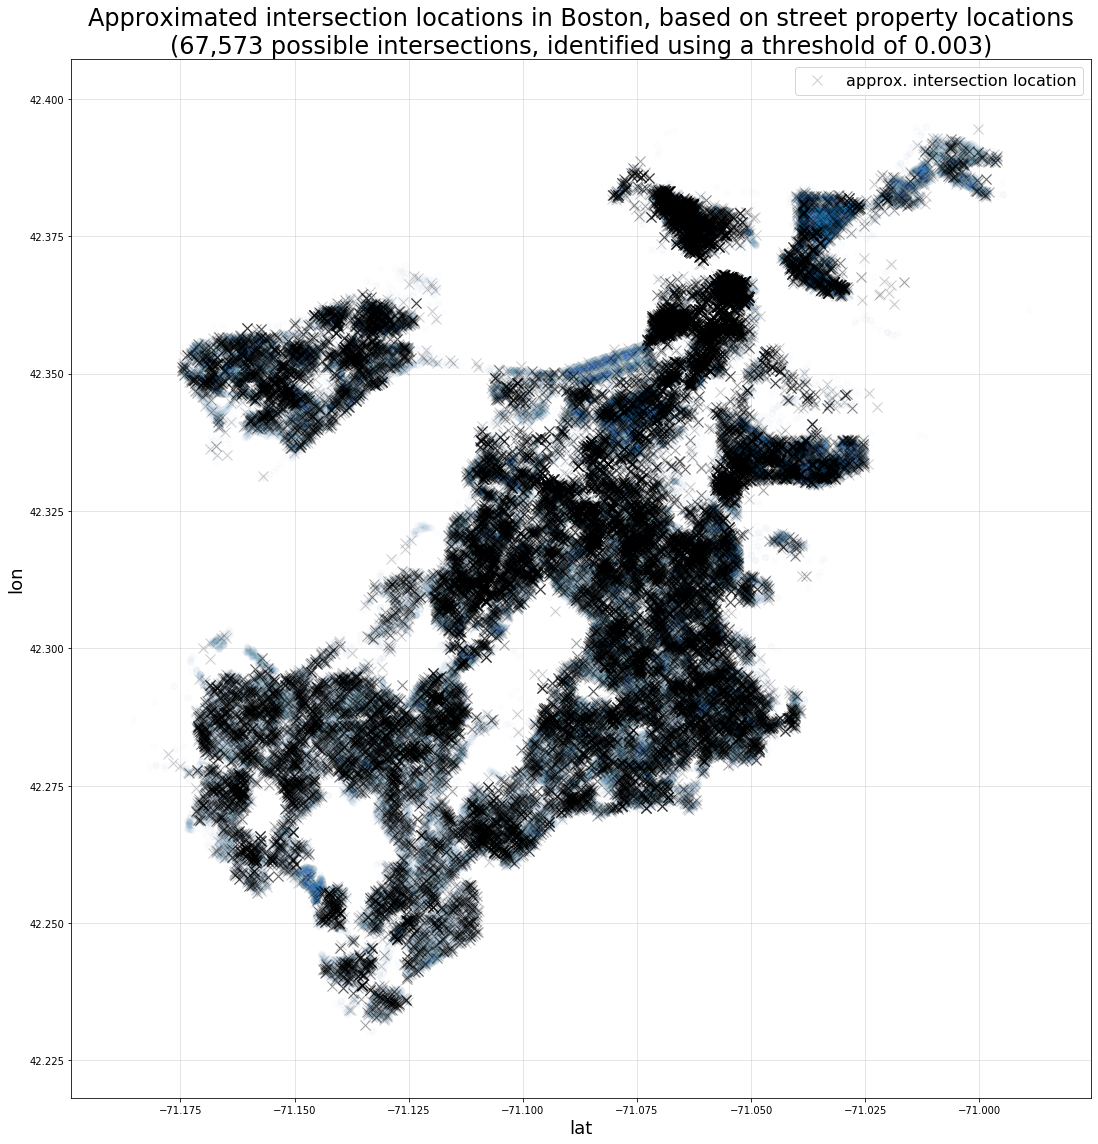

CPU times: user 2.24 s, sys: 8.04 ms, total: 2.25 s
Wall time: 2.25 s


In [100]:
%%time

fig, ax = plt.subplots(figsize=(16,16))
plt.title(
    'Approximated intersection locations in Boston, based on street property locations\n'\
    '({0:,} possible intersections, identified using a threshold of {1})'.format(
        len(intersections_df_003),
        threshold
    ), 
    fontsize=24
)
plt.scatter(
    df_locs['X'],
    df_locs['Y'],
    alpha=0.01
)
plt.plot(
    intersections_df_003['lat'],
    intersections_df_003['lon'],
    'kx',
    markersize=10,
    alpha=0.2,
    label='approx. intersection location'
)
plt.xlabel('lat', fontsize=18)
plt.ylabel('lon', fontsize=18)
plt.grid(":", alpha=0.4)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show();